In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.decomposition import PCA

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, setup, compression, ncd_evaluation
import midi
import midi.decode
from midi import generators as g
from utils import io, models_io, utils, plot, string
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [4]:
context = setup.init(max_bars=4)

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 20.0 0.25
 >> Context(max_t=4.0, dt=0.025, n_timesteps=160, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  160.000000
 max_f: 20.000000, min_f: 0.250000


In [5]:
n = 500 * 1
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.NONE # GLOBAL
dn = 'drum_midi/'
v = None # float | None
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, 
    dirname=dn, multiTrack=multiTrack, velocity=v, r=True)


Importing midi-data
walk_and_search(../datasets/drum_midi/)
path ../datasets/drum_midi/
path ../datasets/drum_midi/50´s Drummer MIDI Files
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM
  01 8th Hat.mid
  02 8th Ride.mid
  03 16th Snare.mid
  04 8th Ride.mid
  05 16th Ride.mid
  06 16th Ride.mid
  07 16th Ride.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM
  01 8th Hat.mid
  02 8th Snare.mid
  03 4th Snare .mid
  04 8th Ride.mid
  05 8th Snare.mid
  06 8th Toms.mid
  07 8th Toms.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/03 Lips n Hips 152BPM
  01 8th Perc.mid
  02 8th Ride.mid
  03 8th Ride .mid
  04 8th Snare.mid
  05 8th Snare.mid
  06 8th Hat.mid
  07 8th Snare.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/04 Maybelline 233BPM
  01 8th Snare.mid
  02 8th Cym.mid
  03 8th Ride.mid
  04 16t


Encoding midi-data
 500
> -> multi-track = True none
 [INFO] : 
 |  True


In [6]:
genres = [string.extract_labels_from_filename(k) for k in labels]
# genre_dict = setup.build_label_dict(genres)

In [7]:
[(i,k) for i,k in enumerate(labels)]

[(0,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid"),
 (1,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/02 8th Ride.mid"),
 (2,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/03 16th Snare.mid"),
 (3,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/04 8th Ride.mid"),
 (4,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/05 16th Ride.mid"),
 (5,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/06 16th Ride.mid"),
 (6,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/07 16th Ride.mid"),
 (7,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/01 8th Hat.mid"),
 (8,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/02 8th Snare.mid"),
 (9,
  "../datasets/

In [8]:
genres[0][-2:]

["01 Rock'n'Roll", '01 Dancin Rick 166BPM']

In [9]:
unique_genres = set(genre[-1] for genre in genres)
len(unique_genres)

72

In [10]:
x_train.shape

(500, 160, 10, 1)

In [13]:
# genres = [string.extract_labels_from_filename(k) for k in labels]
genre_dict = setup.build_label_dict(genres)

In [14]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(160, 10, 1)

In [15]:
latent_dim = 10
epsilon_std = 1.0

In [16]:
vae, encoder, generator = models.build(input_shape, latent_dim)

/usr/local/lib/python3.6/site-packages/keras/layers/core.py:642: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `[(None, 10), (None, 10)]` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
/Users/mark/src/pattern-recognition/src/models.py:147: UserWarning: Output "decoder_model-" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder_model-" during training.
  vae.compile(optimizer='adam')


In [17]:
batch_size = 128
epochs = 500

In [20]:
name = 'non-functional_model.h5'
fn = config.model_dir + name

In [21]:
# io.save_dict('../logs/','train_loss', history)

In [22]:
# # for suffix, model in [('vae',vae), ('encoder',encoder), ('gen',generator)]:
# #     model.save_weights(dn + prefix + suffix + '.h5', "w")
# vae.save_weights(fn, "w")

In [23]:
vae.load_weights(fn)

In [24]:
# plt.plot(history['loss'])
# plt.plot(history['val_loss'])
# plt.ylim(0,150)

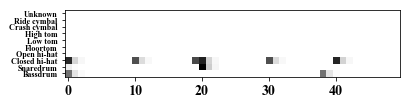

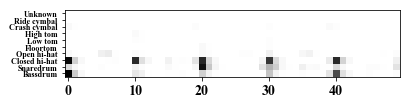

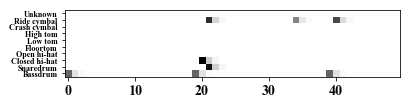

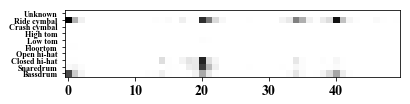

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [25]:
i,j = 0, 10
m = 50
y = vae.predict(x_train[:500])
plot.single(x_train[i,:m])
plot.single(y[i,:m])
plot.single(x_train[j,:m])
plot.single(y[j,:m])

In [26]:
# x = datagen.shuffle_3rd_dim_soft(x_train[:10], rate=1, intensity=2, scale=1, verbose=1)
# i = 0
# plot.single(x_train[i,:,:,0])
# plot.single(x[i,:,:,0])
# x_ = vae.predict(x)
# plot.single(x_[i,:,:,0])

In [27]:
# # min: these pixels are 'always' active
# m = x.min(axis=0)
# plot.multi(m[:30,:,0])

In [28]:
# # mean
# m = x.mean(axis=0)
# plot.single(m[:30,:,0])

## Style transfer

In [29]:
m = 1000
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(450, 10)

In [30]:
# dn = config.plots_dir + 'transformations.pkl'
# io.save(transformations, fn)
# # transformation_extraction.save_to_disk(transformations, dn, v=1)

# fn = config.plots_dir + 'min_transformations.pkl'
# io.save(min_transformations, fn)
# # transformation_extraction.save_to_disk(min_transformations, dn)

In [31]:
fn = config.plots_dir + 'transformations-best_dims.pkl'
best_dims = io.load(fn)
fn = config.plots_dir + 'transformations.pkl'
transformations = io.load(fn)
fn = config.plots_dir + 'min_transformations.pkl'
min_transformations = io.load(fn)

(array([317.,  80.,  69.,  21.,  51.,  67., 102.,  46.,  46., 188.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

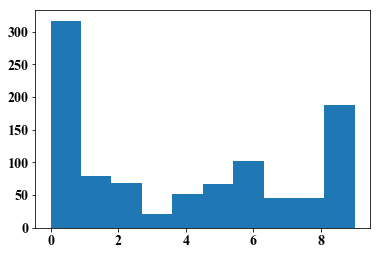

In [32]:
plt.hist(best_dims)

In [33]:
# transformations = io.read_categorical_dict_dir(config.plots_dir + 'transformations/')
# min_transformations = io.read_categorical_dict_dir(config.plots_dir + 'min_transformations/') 

In [34]:
list(transformations.keys())[:3]

['02 Blues/02 Nappy Brown 160BPM',
 '03 Traditional Pop/04 Love 155BPM',
 '04 Country/07 Trainy 100BPM']

In [35]:
len(transformations.keys())

65

In [36]:
# io.save(result, config.plots_dir + 'ncd_evaluation_results.pkl')
labelled_result = io.load(config.plots_dir + 'ncd_evaluation_AB.pkl')
labelled_result_min = io.load(config.plots_dir + 'ncd_evaluation_AB_min.pkl')

In [37]:
def sample_dict(d, i=0):
    k = list(d.keys())[i]
    return k, d[k]

In [38]:
# utils.reload(utils)
labelled_result = utils.clean_dict(labelled_result, r=2, verbose=1)

In [39]:
# utils.reload(utils)
sample = utils.get(labelled_result, i=10)[0]
sample

"01 Rock'n'Roll/07 Thwag 170BPM"

In [40]:
# labelled_result[sample]

In [41]:
genre_a = utils.get(labelled_result[sample])[0]
genre_b,_, scores = utils.get(labelled_result[sample][genre_a])
scores_min = utils.get(labelled_result[sample][genre_a])[2]
xlabels = np.round(list(scores.keys()), 2)
genre_a, genre_b

("01 Rock'n'Roll/07 Thwag 170BPM", '03 Traditional Pop/04 Love 155BPM')

In [42]:
# # for k,v in scores.items():
# #     print('%s: \t%f' % (k,v))
# print(xlabels)
# plot.custom({sample: list(scores.values())}, options={'x_labels': xlabels},
#             type_='bar', y_scale_margin=0.01, show=True)

In [43]:
# plot.custom({sample: list(scores_min.values())}, options={'x_labels': xlabels},
#             type_='bar', y_scale_margin=0.01, show=True)

In [44]:
genre_dict[sample], sample

([42, 43, 44, 45, 46, 47, 48], "01 Rock'n'Roll/07 Thwag 170BPM")

Original


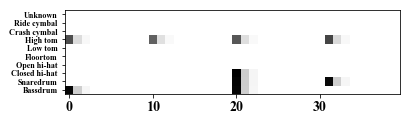

Identity (transformation)


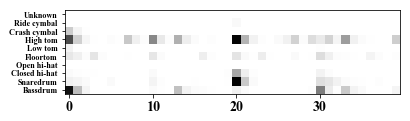

In [45]:
utils.reload(plot, midi.pitches)
z_sample = x_train_encoded[genre_dict[genre_a][0]]
print('Original')
plot.single(x_train[genre_dict[sample][0]][:40])
print('Identity (transformation)')
plot.single(generator.predict(np.array([z_sample]))[0,:40]);

In [46]:
transformation = transformations[genre_a][genre_b]
min_transformation = min_transformations[genre_a][genre_b]
z_transformed = []
z_transformed_min = []
d = {}
for a in [0, 0.125, 0.2, 0.21, 0.22, 0.24]:
    z_ = models.apply_transformation(z_sample, transformation, a)
    z_transformed.append(z_)
    z_ = models.apply_transformation(z_sample, min_transformation, a)
    z_transformed_min.append(z_)

x_generated = generator.predict(np.array(z_transformed))
x_generated_min = generator.predict(np.array(z_transformed_min))

01 Rock'n'Roll/07 Thwag 170BPM 
  01 Rock'n'Roll/07 Thwag 170BPM 	-> 03 Traditional Pop/04 Love 155BPM 


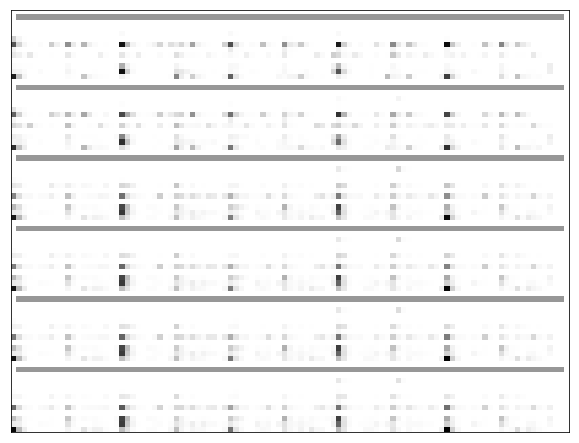

In [47]:
print('%s \n  %s \t-> %s '%(sample, genre_a, genre_b))
# latent_space = models.gen_latent(generator, latent_dim=latent_dim, n=3, m=2, plot_result=True)
plot.multi(x_generated, crop_size=100)

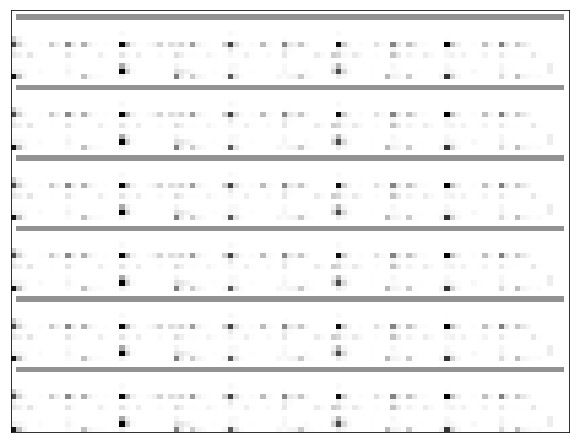

In [48]:
plot.multi(x_generated_min, crop_size=100)

In [49]:
# utils.reload(midi, midi.decode)
for i in range(x_generated.shape[0]):
    x_ = x_generated[i]
    mid = midi.decode.track(context, x_)
    io.export_midifile(mid, config.export_dir + ('x-generated-%i'%i))
    x_ = x_generated_min[i]
    mid = midi.decode.track(context, x_)    
    io.export_midifile(mid, config.export_dir + ('x-generated_min-%i'%i))    

 [INFO] : 
 |  len, max_t
 |  3.780208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.780208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.530208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.780208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.5302083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.780208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.5302083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.780208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.5302083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.780208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.7802083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.780208333333333
 |  4.0


In [50]:
def summarize(data):
    """data :: {samples: {genre a: {genre b: grid}}}
    grid = {parameter: outcome}
    
    return :: {parameter: [value] }
    """
    summary = collections.defaultdict(list)
    for original in data.keys():
        for genre_a in data[original].keys():
            for genre_b, grid in data[original][genre_a].items():
                for k,v in grid.items():
                    summary[k].append(v)
    return summary

def evaluate(data, verbose=0):
    """
    data :: {parameter: [value] }
    return :: {statistic: {parameter: value}}
    """
    result = utils.summary_multi(data, mode=list)
    std = []
    for k,v in data.items():
        std.append(np.std(v))
    
    result['std'] = std
    if verbose: 
        print(result['mean'])
    return result

In [51]:
result = summarize(labelled_result)
result_min = summarize(labelled_result_min)
xlabels = np.round(list(result.keys()), 3)
summary = evaluate(result)
summary_min = evaluate(result_min)
summary_ = summary.copy() # {'Mean': summary['mean'], 'Median': summary['median']}
summary_min_ = summary_min.copy()
summary_.pop('std')
summary_min_.pop('std');

In [52]:
io.save_dict(config.results_dir, 'ncd_result-summary', summary)
io.save_dict(config.results_dir, 'ncd_result_min-summary', summary_min)

'../results/ncd_result_min-summary.csv'

In [53]:
xlabels

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

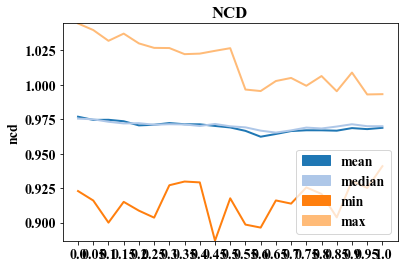

In [54]:
options = {'x_labels': xlabels, 'x_label':'Transformation intensity', 'y_label': 'ncd', 'legend':True}
plot.custom(summary_, 'NCD', options,
            type_='line', min_y_scale=None, max_y_scale=None, y_scale_margin=0.0001, show=True)

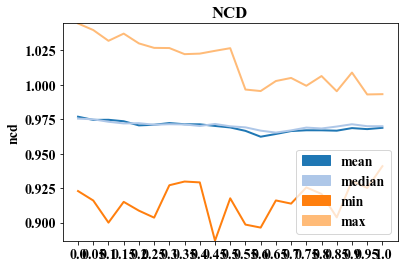

In [55]:
plot.custom(summary_, 'NCD', options,
            type_='line', min_y_scale=None, max_y_scale=None, y_scale_margin=0.0001, show=True)

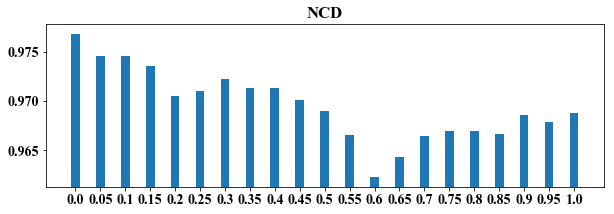

In [91]:
# utils.reload(plot)
options = {'x_labels': xlabels}
figsize = (10,3)
# custom(summary, 'NCD', options, relative=True, show=True)
plot.custom({'Mean':summary['mean']}, 'NCD', options, 
            type_='bar', min_y_scale=None, max_y_scale=None, y_scale_margin=0.001, figsize=figsize, show=True)

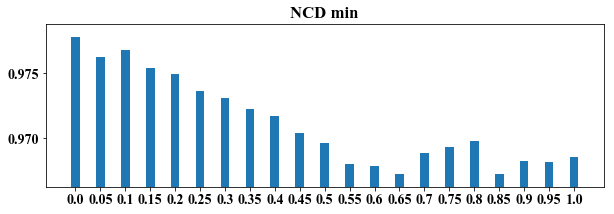

In [92]:
# utils.reload(plot)
plot.custom({'Mean':summary_min['mean']}, 'NCD min', options, 
            type_='bar', min_y_scale=None, max_y_scale=None, y_scale_margin=0.001, figsize=figsize, show=True)

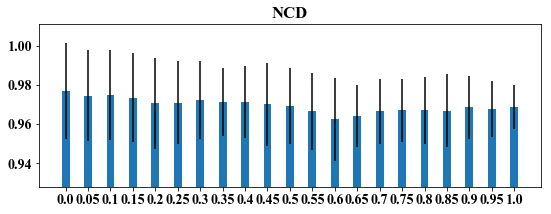

In [98]:
# utils.reload(plot)
options = {'x_labels': xlabels,}
# custom(summary, 'NCD', options, relative=True, show=True)
std = {'Mean': summary['std'], 'Median': summary['std']}
plot.custom({'Mean':summary['mean']}, 'NCD', options, type_='bar',
            std=std, figsize=(9,3),min_y_scale=None, max_y_scale=None, y_scale_margin=0.01, show=True)

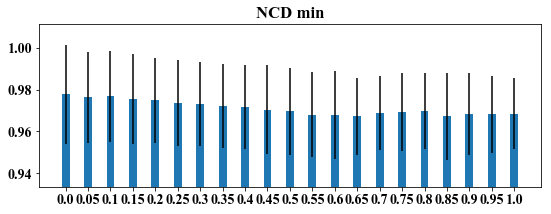

In [97]:
std_min = {'Mean': summary_min['std'], 'Median': summary_min['std']}
plot.custom({'Mean':summary_min['mean']}, 'NCD min', options, type_='bar',
            std=std_min, figsize=(9,3),min_y_scale=None, max_y_scale=None, y_scale_margin=0.01, show=True)

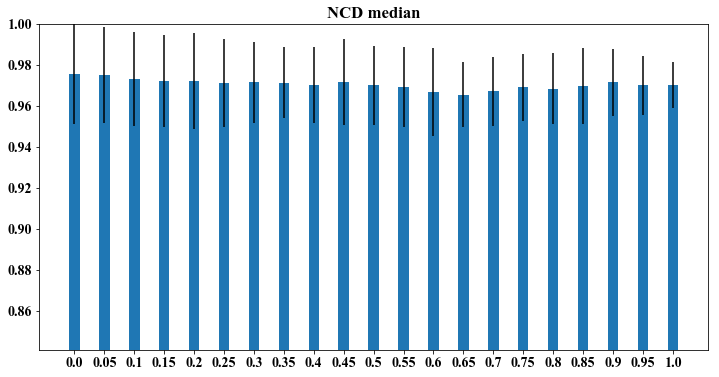

In [96]:
plot.custom({'Median':summary['median']}, 'NCD median', options, type_='bar', std=std, show=True)

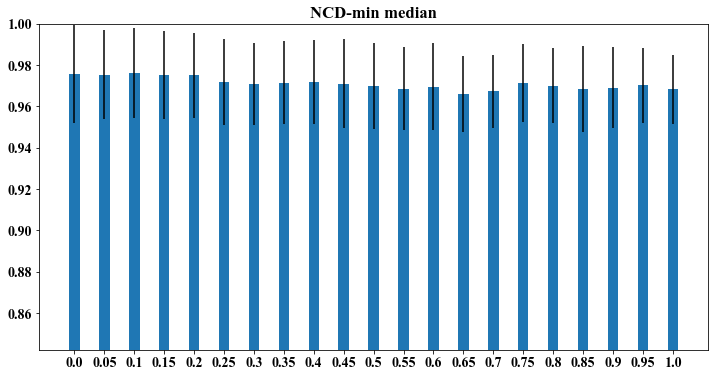

In [95]:
plot.custom({'Median':summary_min['median']}, 'NCD-min median', options, type_='bar', std=std_min, show=True)

In [62]:
result.keys()

dict_keys([0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.65, 0.7000000000000001, 0.75, 0.8, 0.8500000000000001, 0.9, 0.9500000000000001, 1.0])

In [63]:
import scipy.stats

In [64]:
# assume all distributions are related, do not shuffle
# i.e. param1[0] is related to param2[0]
def evaluate(data, base_k=0, f=scipy.stats.ttest_rel, p=0.05,win_c=lambda x,y: x>y):
    result = {}
    base_v = data[base_k]
    for k,v in data.items():
        if len(v) < 1:
            raise(ValueError('Warning: len(v) == %i for k: %s'%(len(v), str(k))))
        if not k == base_k:
            score = scipy.stats.ttest_rel(base_v, v)
            won = win_c(np.mean(base_v), np.mean(v))
            significant = score.pvalue < p
            result['%s/%s' % (base_k,k)] = (won, significant)
            print('%s vs %s: \t' % (base_k, k), won, significant, round(score.pvalue,4))

In [65]:
evaluate(result)

0 vs 0.05: 	 True False 0.0863
0 vs 0.1: 	 True False 0.0682
0 vs 0.15000000000000002: 	 True True 0.0472
0 vs 0.2: 	 True True 0.0015
0 vs 0.25: 	 True True 0.0012
0 vs 0.30000000000000004: 	 True True 0.0175
0 vs 0.35000000000000003: 	 True True 0.0151
0 vs 0.4: 	 True True 0.0247
0 vs 0.45: 	 True True 0.0305
0 vs 0.5: 	 True True 0.0082
0 vs 0.55: 	 True True 0.002
0 vs 0.6000000000000001: 	 True True 0.0002
0 vs 0.65: 	 True True 0.0004
0 vs 0.7000000000000001: 	 True True 0.0007
0 vs 0.75: 	 True True 0.0014
0 vs 0.8: 	 True True 0.0029
0 vs 0.8500000000000001: 	 True True 0.0058
0 vs 0.9: 	 True True 0.0154
0 vs 0.9500000000000001: 	 True True 0.0057
0 vs 1.0: 	 True True 0.0087


In [66]:
evaluate(result_min)

0 vs 0.05: 	 True True 0.0355
0 vs 0.1: 	 True False 0.1379
0 vs 0.15000000000000002: 	 True True 0.0227
0 vs 0.2: 	 True True 0.0064
0 vs 0.25: 	 True True 0.001
0 vs 0.30000000000000004: 	 True True 0.0002
0 vs 0.35000000000000003: 	 True True 0.0009
0 vs 0.4: 	 True True 0.0014
0 vs 0.45: 	 True True 0.0054
0 vs 0.5: 	 True True 0.0011
0 vs 0.55: 	 True True 0.0007
0 vs 0.6000000000000001: 	 True True 0.001
0 vs 0.65: 	 True True 0.0002
0 vs 0.7000000000000001: 	 True True 0.0002
0 vs 0.75: 	 True True 0.0003
0 vs 0.8: 	 True True 0.001
0 vs 0.8500000000000001: 	 True True 0.0007
0 vs 0.9: 	 True True 0.0004
0 vs 0.9500000000000001: 	 True True 0.0002
0 vs 1.0: 	 True True 0.0001


In [67]:
evaluate(result_min, base_k=0, f=scipy.stats.ttest_ind)

0 vs 0.05: 	 True True 0.0355
0 vs 0.1: 	 True False 0.1379
0 vs 0.15000000000000002: 	 True True 0.0227
0 vs 0.2: 	 True True 0.0064
0 vs 0.25: 	 True True 0.001
0 vs 0.30000000000000004: 	 True True 0.0002
0 vs 0.35000000000000003: 	 True True 0.0009
0 vs 0.4: 	 True True 0.0014
0 vs 0.45: 	 True True 0.0054
0 vs 0.5: 	 True True 0.0011
0 vs 0.55: 	 True True 0.0007
0 vs 0.6000000000000001: 	 True True 0.001
0 vs 0.65: 	 True True 0.0002
0 vs 0.7000000000000001: 	 True True 0.0002
0 vs 0.75: 	 True True 0.0003
0 vs 0.8: 	 True True 0.001
0 vs 0.8500000000000001: 	 True True 0.0007
0 vs 0.9: 	 True True 0.0004
0 vs 0.9500000000000001: 	 True True 0.0002
0 vs 1.0: 	 True True 0.0001
